

*   Flight Delay Dataset

This dataset contains 3M flight records (32 columns) tracking airline delays (2019-2023), enabling predictive modeling to help travelers and airlines minimize travel disruptions through optimized scheduling.



In [1]:
# Check GPU availability
!nvidia-smi

Thu Apr 17 11:27:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# STEP 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import classification_report, confusion_matrix
import cudf
import cuml
import cupy as cp
from cuml.metrics import accuracy_score
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.model_selection import train_test_split
import xgboost as xgb
import joblib

In [3]:
# Step 2: Load data
start_time = time.time()
df = pd.read_csv('/content/flights_sample_3m.csv')
load_time = time.time() - start_time
print(f"Data loaded in {load_time:.2f} seconds")
print("\n===== DATASET INFO =====")
print(df.info())
print("\n===== SAMPLE DATA =====")
print(df.head())
start_time = time.time()
gdf = cudf.DataFrame.from_pandas(df)
gpu_conversion_time = time.time() - start_time
print(f"\nConverted to GPU DataFrame in {gpu_conversion_time:.2f} seconds")
print(gdf.info())

Data loaded in 11.23 seconds

===== DATASET INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                floa

In [4]:
missing_values = df.isnull().sum()
print(missing_values)
print("\nSummary statistics:")
print(df.describe())

FL_DATE                          0
AIRLINE                          0
AIRLINE_DOT                      0
AIRLINE_CODE                     0
DOT_CODE                         0
FL_NUMBER                        0
ORIGIN                           0
ORIGIN_CITY                      0
DEST                             0
DEST_CITY                        0
CRS_DEP_TIME                     0
DEP_TIME                     77615
DEP_DELAY                    77644
TAXI_OUT                     78806
WHEELS_OFF                   78806
WHEELS_ON                    79944
TAXI_IN                      79944
CRS_ARR_TIME                     0
ARR_TIME                     79942
ARR_DELAY                    86198
CANCELLED                        0
CANCELLATION_CODE          2920860
DIVERTED                         0
CRS_ELAPSED_TIME                14
ELAPSED_TIME                 86198
AIR_TIME                     86198
DISTANCE                         0
DELAY_DUE_CARRIER          2466137
DELAY_DUE_WEATHER   

In [5]:
start_time = time.time()
for col in gdf.columns:
    if gdf[col].dtype == 'float64' or gdf[col].dtype == 'float32':
        gdf[col] = gdf[col].fillna(gdf[col].mean())
    elif gdf[col].dtype == 'int64' or gdf[col].dtype == 'int32':
        gdf[col] = gdf[col].fillna(0)
    else:
        if gdf[col].dtype == 'object':
            most_common = gdf[col].value_counts().index[0] if len(gdf[col].value_counts()) > 0 else 'UNKNOWN'
            gdf[col] = gdf[col].fillna(most_common)

In [6]:
nulls_remaining = gdf.isnull().sum().sum()
print(f"Remaining null values after filling: {nulls_remaining}")

Remaining null values after filling: 0


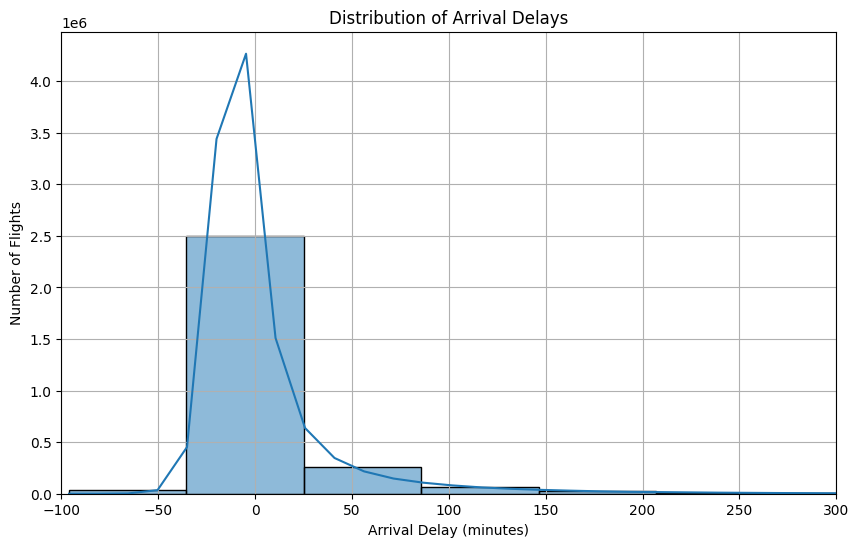

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ARR_DELAY'].dropna(), bins=50, kde=True)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Number of Flights')
plt.xlim(-100, 300)
plt.grid(True)
plt.show()

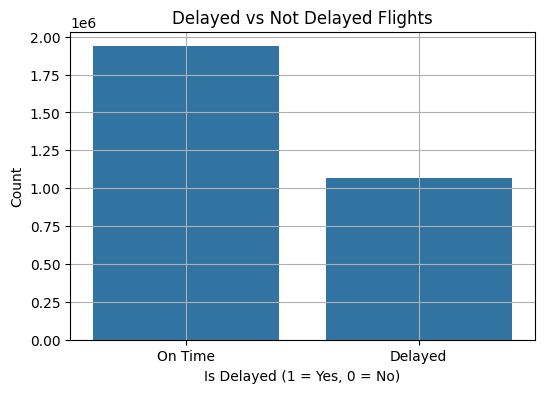

In [8]:
gdf['IS_DELAYED'] = (gdf['ARR_DELAY'] > 0).astype(int)
plt.figure(figsize=(6, 4))
sns.countplot(x='IS_DELAYED', data=gdf.to_pandas())
plt.title('Delayed vs Not Delayed Flights')
plt.xlabel('Is Delayed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['On Time', 'Delayed'])
plt.grid(True)
plt.show()


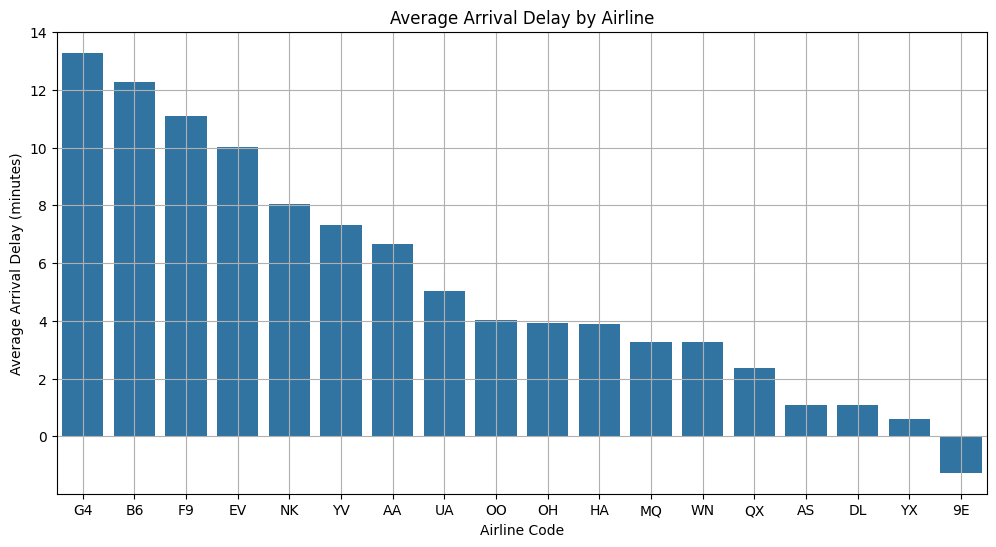

In [9]:
plt.figure(figsize=(12, 6))
airline_delay = df.groupby('AIRLINE_CODE')['ARR_DELAY'].mean().sort_values(ascending=False)
sns.barplot(x=airline_delay.index, y=airline_delay.values)
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Airline Code')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

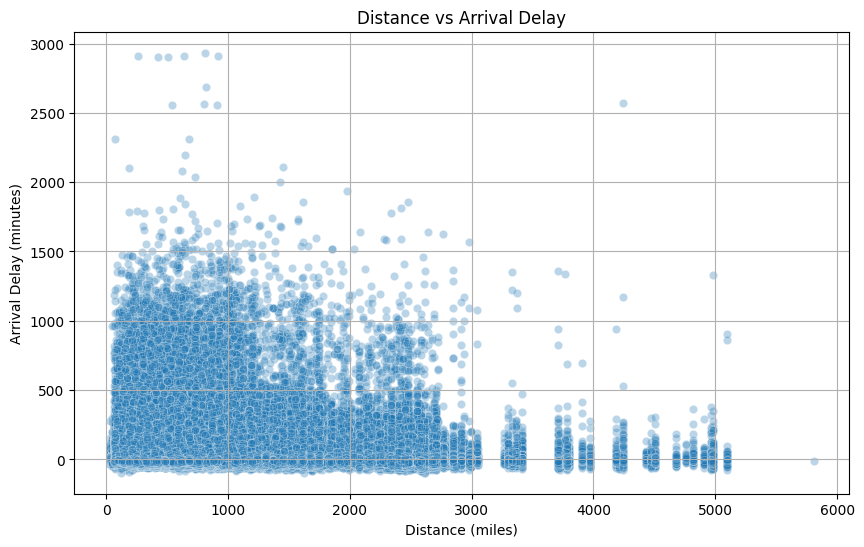

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=df, alpha=0.3)
plt.title('Distance vs Arrival Delay')
plt.xlabel('Distance (miles)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True)
plt.show()

In [11]:
print("Creating features...")

gdf['FL_DATE'] = cudf.to_datetime(gdf['FL_DATE'])
gdf['DAY_OF_WEEK'] = gdf['FL_DATE'].dt.dayofweek
gdf['MONTH'] = gdf['FL_DATE'].dt.month
gdf['YEAR'] = gdf['FL_DATE'].dt.year

gdf['DEP_HOUR'] = gdf['CRS_DEP_TIME'] // 100
gdf['DEP_MINUTE'] = gdf['CRS_DEP_TIME'] % 100

airlines = gdf['AIRLINE'].unique().to_pandas()
airline_dict = {airline: idx for idx, airline in enumerate(airlines)}
gdf['AIRLINE_NUM'] = gdf['AIRLINE'].map(airline_dict)

top_origins = gdf['ORIGIN'].value_counts().nlargest(30).index.to_pandas()
top_dests = gdf['DEST'].value_counts().nlargest(30).index.to_pandas()
gdf['MAJOR_ORIGIN'] = gdf['ORIGIN'].isin(top_origins).astype(int)
gdf['MAJOR_DEST'] = gdf['DEST'].isin(top_dests).astype(int)

gdf['IS_DELAYED'] = (gdf['ARR_DELAY'] > 15).astype(int)
gdf['IS_DELAYED'] = gdf['IS_DELAYED'].fillna(0)

gdf['DISTANCE_CAT'] = pd.cut(
    gdf['DISTANCE'].to_pandas(),
    bins=[0, 500, 1000, 1500, 10000],
    labels=[0, 1, 2, 3]
).astype('int32')

preprocess_time = time.time() - start_time
print(f"Preprocessing completed in {preprocess_time:.2f} seconds")

Creating features...
Preprocessing completed in 28.91 seconds


In [12]:
print("\n FEATURE SELECTION ")
start_time = time.time()


leakage_cols = [
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME', 'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

selected_features = [
    'DISTANCE', 'CRS_ELAPSED_TIME',
    'DEP_HOUR', 'DAY_OF_WEEK', 'MONTH', 'YEAR',
    'AIRLINE_NUM', 'MAJOR_ORIGIN', 'MAJOR_DEST',
    'DISTANCE_CAT'
]

X = gdf[selected_features]
y = gdf['IS_DELAYED']
for col in X.columns:
    if X[col].dtype == 'float64' or X[col].dtype == 'float32':
        X[col] = X[col].fillna(X[col].mean())
    elif X[col].dtype == 'int64' or X[col].dtype == 'int32':
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].fillna(0)

print(f"Nulls in X: {X.isnull().sum().sum()}")
print(f"Nulls in y: {y.isnull().sum()}")

feature_selection_time = time.time() - start_time
print(f"Feature selection completed in {feature_selection_time:.2f} seconds")
print(f"Selected features: {selected_features}")
print(f"Feature matrix shape: {X.shape}")


 FEATURE SELECTION 
Nulls in X: 0
Nulls in y: 0
Feature selection completed in 0.03 seconds
Selected features: ['DISTANCE', 'CRS_ELAPSED_TIME', 'DEP_HOUR', 'DAY_OF_WEEK', 'MONTH', 'YEAR', 'AIRLINE_NUM', 'MAJOR_ORIGIN', 'MAJOR_DEST', 'DISTANCE_CAT']
Feature matrix shape: (3000000, 10)


In [13]:
try:
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    split_method = "stratified"
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using regular train-test split instead")
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    split_method = "regular"

split_time = time.time() - start_time
print(f"Train-test split ({split_method}) completed in {split_time:.2f} seconds")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Train-test split (stratified) completed in 0.26 seconds
Training data shape: (2400000, 10)
Testing data shape: (600000, 10)


In [14]:
train_delayed = y_train.mean() * 100
test_delayed = y_test.mean() * 100
print(f"Training set - Delayed flights: {train_delayed:.2f}%")
print(f"Test set - Delayed flights: {test_delayed:.2f}%")

neg_class_count = (y_train == 0).sum()
pos_class_count = (y_train == 1).sum()
total = neg_class_count + pos_class_count
class_weights = {
    0: total / (2 * neg_class_count),
    1: total / (2 * pos_class_count)
}
print(f"Class weights: {class_weights}")

Training set - Delayed flights: 17.18%
Test set - Delayed flights: 17.18%
Class weights: {0: np.float64(0.6036918776779394), 1: np.float64(2.9109892269140363)}


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=100, class_weight=class_weights)
lr_model.fit(X_train_np, y_train_np)
lr_pred = lr_model.predict(X_test_np)
lr_accuracy = accuracy_score(y_test_np, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


scaler = StandardScaler()
scaler.fit(X_train_np)


Training Logistic Regression...
Logistic Regression Accuracy: 0.5782


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StandardScaler()

In [20]:
# Random Forest
print("\nTraining Random Forest...")
start_time = time.time()

# Initialize model_metrics as a list
model_metrics = []

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_time
print(f"Random Forest trained in {rf_train_time:.2f} seconds")

rf_pred = rf_model.predict(X_test)
rf_pred_np = rf_pred.to_numpy()
y_test_np = y_test.to_numpy()
rf_accuracy = accuracy_score(y_test_np, rf_pred_np)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


rf_predict_time = time.time() - start_time
print(f"Random Forest prediction completed in {rf_predict_time:.2f} seconds")

model_metrics.append({
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy
})



Training Random Forest...
Random Forest trained in 13.73 seconds
Random Forest Accuracy: 0.8286
Random Forest prediction completed in 19.48 seconds


In [25]:
# 3. XGBoost
print("\nTraining XGBoost...")
start_time = time.time()
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_time
print(f"XGBoost trained in {xgb_train_time:.2f} seconds")

xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test_np, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
joblib.dump(rf_model, 'XGBoost_model.joblib')

xgb_predict_time = time.time() - start_time
print(f"XGBoost prediction completed in {xgb_predict_time:.2f} seconds")

model_metrics.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_accuracy
})


Training XGBoost...
XGBoost trained in 18.53 seconds
XGBoost Accuracy: 0.8290
XGBoost prediction completed in 27.15 seconds


In [26]:
# Predict
start_time = time.time()
xgb_pred_proba = xgb_model.predict(X_test) # Changed dtest to X_test
xgb_pred = (xgb_pred_proba > 0.5).astype(int)
xgb_predict_time = time.time() - start_time
print(f"XGBoost prediction completed in {xgb_predict_time:.2f} seconds")

# Evaluate
xgb_report = classification_report(y_test_np, xgb_pred, output_dict=True)
xgb_cm = confusion_matrix(y_test_np, xgb_pred)

print(f"\nXGBoost Performance:")
print(f"  Accuracy: {np.mean(xgb_pred == y_test_np):.4f}")

XGBoost prediction completed in 2.15 seconds

XGBoost Performance:
  Accuracy: 0.8290


In [27]:
import pandas as pd

model_metrics = []

model_metrics.append({
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy,
    'Train Time (seconds)': rf_train_time,
    'Predict Time (seconds)': rf_predict_time
})

model_metrics.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_accuracy,
    'Train Time (seconds)': xgb_train_time,
    'Predict Time (seconds)': xgb_predict_time
})

df = pd.DataFrame(model_metrics)

print("Model Performance Summary:")
print(df)

best_model_row = df.loc[df['Accuracy'].idxmax()]

print("\nBest Model Performance:")
print(best_model_row)

best_model_name = best_model_row['Model']
best_model_accuracy = best_model_row['Accuracy']
best_model_train_time = best_model_row['Train Time (seconds)']
best_model_predict_time = best_model_row['Predict Time (seconds)']

print("\nBest Model Summary:")
print(f"Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy:.4f}")
print(f"Training Time: {best_model_train_time:.2f} seconds")
print(f"Prediction Time: {best_model_predict_time:.2f} seconds")


Model Performance Summary:
           Model  Accuracy  Train Time (seconds)  Predict Time (seconds)
0  Random Forest  0.828640             13.726828               19.482852
1        XGBoost  0.829008             18.534012                2.147779

Best Model Performance:
Model                       XGBoost
Accuracy                   0.829008
Train Time (seconds)      18.534012
Predict Time (seconds)     2.147779
Name: 1, dtype: object

Best Model Summary:
Model: XGBoost
Accuracy: 0.8290
Training Time: 18.53 seconds
Prediction Time: 2.15 seconds
